#### Notebook setup

In [169]:
import time
import warnings
import os, sys
from copy import deepcopy
from types import SimpleNamespace
from pprint import pprint as print

import matplotlib.pyplot as plt
import gym
import numpy as np
from tqdm.auto import tqdm, trange

from multirotor.helpers import control_allocation_matrix, DataLog
from multirotor.vehicle import MotorParams, VehicleParams, PropellerParams, SimulationParams, BatteryParams
from multirotor.controller import (
    PosController, VelController,
    AttController, RateController,
    AltController, AltRateController,
    Controller
)
from multirotor.simulation import Multirotor, Propeller, Motor, Battery
from multirotor.coords import body_to_inertial, inertial_to_body, direction_cosine_matrix, euler_to_angular_rate
from multirotor.env import SpeedsMultirotorEnv, DynamicsMultirotorEnv
from multirotor.trajectories import Trajectory
from multirotor.visualize import plot_datalog
from multirotor.optimize import optimize, DEFAULTS, run_sim, apply_params

from environments import OctorotorEnvSelector
from systems.pid_agent import PIDAgent

In [170]:
# Tarot T18 params
bp = BatteryParams(max_voltage=22.2)
mp = MotorParams(
    moment_of_inertia=5e-5,
    # resistance=0.27,
    resistance=0.081,
    k_emf=0.0265,
    # k_motor=0.0932,
    speed_voltage_scaling= 0.0347,
    max_current=38.
)
pp = PropellerParams(
    moment_of_inertia=1.86e-6,
    use_thrust_constant=True,
    k_thrust=9.8419e-05, # 18-inch propeller
    # k_thrust=5.28847e-05, # 15 inch propeller
    k_drag=1.8503e-06, # 18-inch propeller
    # k_drag=1.34545e-06, # 15-inch propeller
    motor=mp
)
vp = VehicleParams(
    propellers=[pp] * 8,
    battery=bp,
    # angles in 45 deg increments, rotated to align with
    # model setup in gazebo sim (not part of this repo)
    angles=np.linspace(0, -2*np.pi, num=8, endpoint=False) + 0.375 * np.pi,
    distances=np.ones(8) * 0.635,
    clockwise=[-1,1,-1,1,-1,1,-1,1],
    mass=10.66,
    inertia_matrix=np.asarray([
        [0.2206, 0, 0],
        [0, 0.2206, 0.],
        [0, 0, 0.4238]
    ])
)
sp = SimulationParams(dt=0.01, g=9.81)

### Parameters

In [171]:
nasa_wp = np.asarray([ # defines a real trajectory shown in a NASA paper
    [164.0146725649829, -0.019177722744643688, 30],
    [165.6418055187678, 111.5351051245816, 30],
    [127.3337449710234, 165.73576059611514, 30],
    [-187.28170707810204, 170.33217775914818, 40],
    [-192.03130502498243, 106.30660058604553, 40],
    [115.89920266153058, 100.8644210617058, 30],
    [114.81859536317643, 26.80923518165946, 30],
    [-21.459931490011513, 32.60508110653609, 30]
])

In [172]:
best_agent = PIDAgent()
best_params = {'steps_u':1, 'scaling_factor':0, 'window_distance':1000}
env_selector = OctorotorEnvSelector()
square_wpts = np.array([[100,0,30], [100,100,30], [0,100,30], [0,0,30]])
references = []
errors = []
speeds = []

def run_trajectory(env_selector, wind_ranges: np.ndarray, agent, params):
    env = env_selector.get_env("sliding", params, wind_ranges, nasa_wp, start_alt=30, has_turbulence=False)
    params = env.base_env.ctrl.get_params()
    params['ctrl_p']['max_velocity'] = 15
    params['ctrl_v']['max_tilt'] = np.deg2rad(22.5)
    # params['ctrl_v']['k_i'] = params['ctrl_v']['k_p'] * 10# / 10
    
    env.base_env.ctrl.set_params(**params)
    done = False
    state = np.array(env.reset(), dtype=np.float32)
    log = DataLog(env.base_env.vehicle, env.base_env.ctrl,
                      other_vars=('reward',))
    while not done:
        action = agent.predict(state, deterministic=True)[0]
        state, reward, done, info = env.step(action)
        state = np.array(state, dtype=np.float32)
        log.log(reward=reward)
        errors.append([env.base_env.ctrl.ctrl_v.err_p, env.base_env.ctrl.ctrl_v.err_i])
        # speeds.append([log.vehicle.speeds])
        speeds.append([env.base_env.vehicle.speeds])
        
        
        # references.append(log.c)

    log.done_logging()
    return log, info, np.array(errors), np.array(speeds)

# log, info, errors, speeds = run_trajectory(env_selector, [(12,12), (0,0), (0,0)], best_agent, best_params)

In [173]:
env = env_selector.get_env("sliding", best_params, [(0,0),(0,0),(0,0)], square_wpts, start_alt=30, has_turbulence=False)
params = env.base_env.ctrl.get_params()

In [174]:
params

{'ctrl_p': {'k_p': array([0.38, 0.38]),
  'k_i': array([0., 0.]),
  'k_d': array([0., 0.]),
  'max_err_i': array(1.),
  'max_velocity': 15,
  'max_acceleration': 3.0,
  'max_jerk': 100.0,
  'square_root_scaling': False,
  'leashing': False},
 'ctrl_v': {'k_p': array([0.08, 0.08]),
  'k_i': array([0., 0.]),
  'k_d': array([0., 0.]),
  'max_err_i': array(3.),
  'max_tilt': 0.2617993877991494},
 'ctrl_a': {'k_p': array([2., 2., 2.]),
  'k_i': array([0., 0., 0.]),
  'k_d': array([0., 0., 0.]),
  'max_err_i': array(1.),
  'max_acceleration': 0.2,
  'max_jerk': 100.0,
  'square_root_scaling': False},
 'ctrl_r': {'k_p': array([10., 10., 10.]),
  'k_i': array([0., 0., 0.]),
  'k_d': array([0., 0., 0.]),
  'max_err_i': array(0.5),
  'max_acceleration': array([8.3891751 , 8.3891751 , 0.35866418])},
 'ctrl_z': {'k_p': array([0.4], dtype=float32),
  'k_i': array([0.], dtype=float32),
  'k_d': array([0.], dtype=float32),
  'max_err_i': array(1., dtype=float32),
  'max_velocity': array([1])},
 'ctrl

### PID Controller

In [175]:
ctrl = env.base_env.ctrl

In [176]:
optimal_params = ctrl.get_params()

#### Attitude Rate Controller

In [177]:
# optimal_params['ctrl_a']['k_p'] = np.array([5, 5, 5]) - 3
# optimal_params['ctrl_a']['k_i'] = np.array([0,0,0])
# optimal_params['ctrl_a']['k_d'] = np.array([0,0,0])

In [178]:
# optimal_params['ctrl_r']['k_p'] = np.array([10, 10, 10])
# optimal_params['ctrl_r']['k_i'] = np.array([0,0,0])
# optimal_params['ctrl_r']['k_d'] = np.array([0,0,0])

In [179]:
optimal_params['ctrl_a']['k_p'] = np.array([5, 5, 5]) - 2
optimal_params['ctrl_a']['k_i'] = np.array([0,0,0])
optimal_params['ctrl_a']['k_d'] = np.array([0,0,0]) + 0.5

In [180]:
optimal_params['ctrl_r']['k_p'] = np.array([10, 10, 10]) - 5
optimal_params['ctrl_r']['k_i'] = np.array([0,0,0])
optimal_params['ctrl_r']['k_d'] = np.array([0,0,0]) 

In [181]:
ctrl.set_params(**optimal_params)

RateController(k_p=array([5., 5., 5.]), k_i=array([0., 0., 0.]), k_d=array([0., 0., 0.]), max_err_i=array(0.5), vehicle=<multirotor.simulation.Multirotor object at 0x7fc4349c70a0>, max_acceleration=array([8.3891751 , 8.3891751 , 0.35866418]))
AttController(k_p=array([3., 3., 3.]), k_i=array([0., 0., 0.]), k_d=array([0.5, 0.5, 0.5]), max_err_i=array(1.), vehicle=<multirotor.simulation.Multirotor object at 0x7fc4349c70a0>, max_acceleration=0.2, max_jerk=100.0, square_root_scaling=False)


Text(0.5, 1.0, 'Angle Controller')

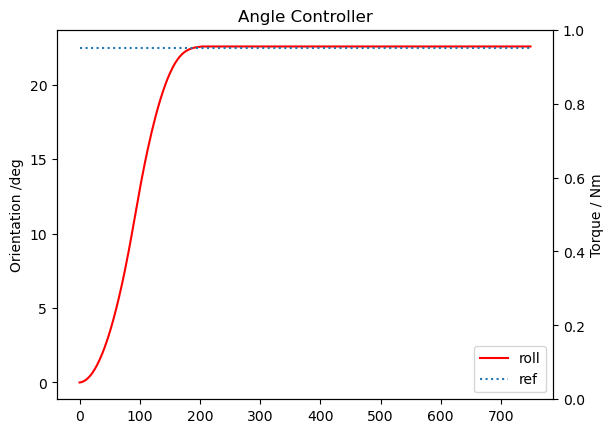

In [182]:
m = Multirotor(vp, sp)
fz = m.weight
rat = ctrl.ctrl_r
print(rat)
att = ctrl.ctrl_a
print(att)
log = DataLog(vehicle=m, controller=ctrl, other_vars=('err',))
for i in range(750):
    ref = np.asarray([0.3926991, 0, 0])
    rate = att.step(ref, m.orientation, m.simulation.dt)
    torque = rat.step(rate, m.euler_rate, m.simulation.dt)
    action = np.clip(torque, a_min=-0.1, a_max=0.1)
    m.step_dynamics(np.asarray([0, 0, 0, *action]))
    log.log(err=rate[0])
    log._actions[-1] = action
log.done_logging()

plt.plot(log.roll * 180 / np.pi, c='r', label='roll')
plt.plot([ref[0] * 180 / np.pi]*750, ls=':', label='ref')

plt.ylabel('Orientation /deg')
plt.legend()
plt.twinx()
plt.ylabel('Torque / Nm')
plt.title("Angle Controller")

# plt.xlim(120, 220)


### Velocity Controller

In [183]:
print(ctrl.ctrl_v)

VelController(k_p=array([0.08, 0.08]), k_i=array([0., 0.]), k_d=array([0., 0.]), max_err_i=array(3.), vehicle=<multirotor.simulation.Multirotor object at 0x7fc4349c70a0>, max_tilt=0.2617993877991494)


In [184]:
optimal_params['ctrl_v']['k_p'] = np.array([0.08, 0.08]) 
optimal_params['ctrl_v']['k_i'] = np.array([0.08,0.08]) / 10
optimal_params['ctrl_v']['k_d'] = np.array([0.01,0.01])*10
optimal_params['ctrl_v']['max_tilt'] = np.deg2rad(22.5)


ctrl.set_params(**optimal_params)

VelController(k_p=array([0.08, 0.08]), k_i=array([0.008, 0.008]), k_d=array([0.1, 0.1]), max_err_i=array(3.), vehicle=<multirotor.simulation.Multirotor object at 0x7fc4349c70a0>, max_tilt=0.39269908169872414)


Text(0.5, 1.0, 'Velocity Controller')

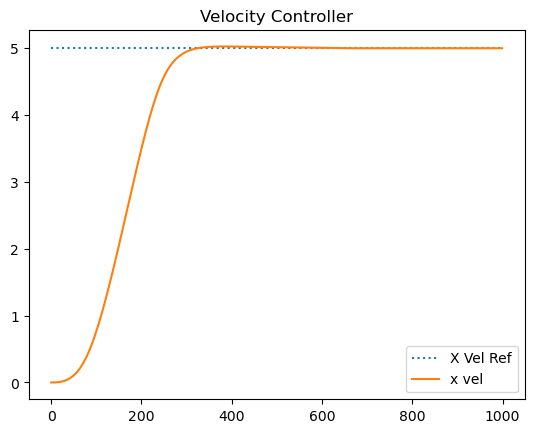

In [185]:
m = Multirotor(vp, sp)
vel = ctrl.ctrl_v
rat = ctrl.ctrl_r
att = ctrl.ctrl_a
print(vel)
log = DataLog(vehicle=m, other_vars=('thrust',))
for i in range(1000):
    ref = np.asarray([5., 0])
    angles = vel.step(ref, m.velocity[:2], dt=0.1)[::-1]
    rate = att.step(np.asarray([*angles, 0]), m.orientation, dt=0.01)
    action = rat.step(rate, m.euler_rate, dt=0.01)
    action = np.clip(action, a_min=-0.1, a_max=0.1)
    # m.step_dynamics(np.asarray([0, 0, 0, 0, 0, 0]))
    m.step_dynamics(np.asarray([0, 0, m.weight, *action]))
    
    log.log(thrust=action)
log.done_logging()

plt.plot([ref[0]]*1000, ls=':', label='X Vel Ref')
plt.plot(log.velocity[:,0], label='x vel')
plt.legend()
plt.title("Velocity Controller")

VelController(k_p=array([0.08, 0.08]), k_i=array([0.008, 0.008]), k_d=array([0.1, 0.1]), max_err_i=array(3.), vehicle=<multirotor.simulation.Multirotor object at 0x7fc4349c70a0>, max_tilt=0.39269908169872414)


Text(0.5, 1.0, 'Velocity Controller No I term')

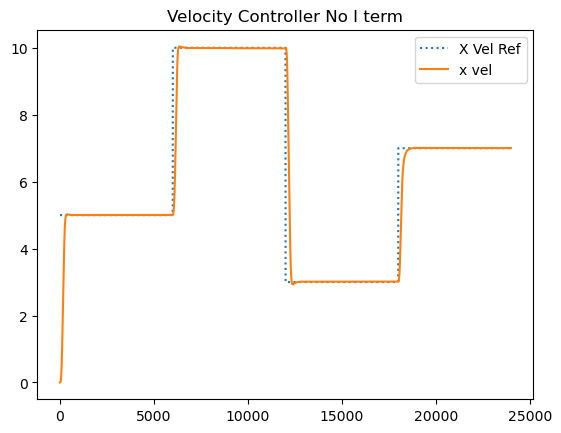

In [186]:
m = Multirotor(vp, sp)
vel = ctrl.ctrl_v
rat = ctrl.ctrl_r
att = ctrl.ctrl_a
print(vel)
log = DataLog(vehicle=m, other_vars=('thrust',))

target_vels = [5, 10,  3, 7]
n_repeat = 60*100
refs = []

for ref_vel in target_vels:
    for i in range(n_repeat):
        ref = np.asarray([ref_vel, 0])
        angles = vel.step(ref, m.velocity[:2], dt=0.1)[::-1]
        rate = att.step(np.asarray([*angles, 0]), m.orientation, dt=0.01)
        action = rat.step(rate, m.euler_rate, dt=0.01)
        action = np.clip(action, a_min=-0.1, a_max=0.1)
        # m.step_dynamics(np.asarray([0, 0, 0, 0, 0, 0]))
        m.step_dynamics(np.asarray([0, 0, m.weight, *action]))
        refs.append(ref[0])
        
        log.log(thrust=action)
log.done_logging()

plt.plot(refs, ls=':', label='X Vel Ref')
plt.plot(log.velocity[:,0], label='x vel')
plt.legend()
plt.title("Velocity Controller No I term")

#### Altitude Controller

In [187]:
# optimal_params['ctrl_z']['k_p'] = np.array([0.1])
# optimal_params['ctrl_z']['k_i'] = np.array([0.05])
# optimal_params['ctrl_z']['k_d'] = np.array([0.01])
# optimal_params['ctrl_z']['max_velocity'] = np.array([1])

# z_params = optimal_params['ctrl_z']

In [188]:
optimal_params['ctrl_z']['k_p']

array([0.4], dtype=float32)

In [189]:
# optimal_params['ctrl_vz']['k_p'] = np.array([5])
# optimal_params['ctrl_vz']['k_i'] = np.array([0])
# optimal_params['ctrl_vz']['k_d'] = np.array([0])

In [190]:
# ctrl.set_params(**optimal_params)

AltController(k_p=array([0.4], dtype=float32), k_i=array([0.], dtype=float32), k_d=array([0.], dtype=float32), max_err_i=array(1., dtype=float32), vehicle=<multirotor.simulation.Multirotor object at 0x7fc4349c70a0>, max_velocity=array([1]))
AltRateController(k_p=25, k_i=array([0]), k_d=array([0]), max_err_i=array(1), vehicle=<multirotor.simulation.Multirotor object at 0x7fc4349c70a0>)


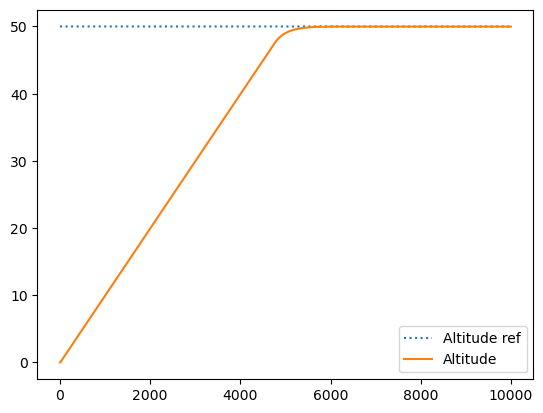

In [191]:
m = Multirotor(vp, sp)
alt = ctrl.ctrl_z
# alt.set_params(**z_params)
print(alt)
alt_rate = ctrl.ctrl_vz
print(alt_rate)
log = DataLog(vehicle=m, other_vars=('thrust',))
for i in range(10000):
    ref = np.asarray([50.])
    rate = alt.step(ref, m.position[2:], dt=0.1)
    action = alt_rate.step(rate, m.inertial_velocity[2:], dt=0.1)
    action = np.clip(action, a_min=-2*m.weight, a_max=2*m.weight)
    m.step_dynamics(np.asarray([0, 0, action[0], 0, 0, 0]))
    log.log(thrust=action)
log.done_logging()

plt.plot([ref]*10000, ls=':', label='Altitude ref')
plt.plot(log.z, label='Altitude')
plt.legend()

#### Position Controller

In [252]:
optimal_params['ctrl_p']['k_p'] = np.array([0.38, 0.38])
# optimal_params['ctrl_a']['k_p'] = np.array([2.68,0, 0])
optimal_params['ctrl_p']['k_i'] = np.array([0.38,0.38]) / 50
optimal_params['ctrl_p']['k_d'] = np.array([0.38,0.38]) / 1.2
ctrl.set_params(**optimal_params)

PosController(k_p=array([0.38, 0.38]), k_i=array([0.0076, 0.0076]), k_d=array([0.31666667, 0.31666667]), max_err_i=array(1.), vehicle=<multirotor.simulation.Multirotor object at 0x7fc4349c70a0>, max_velocity=15, max_acceleration=3.0, max_jerk=100.0, square_root_scaling=False, leashing=False)
VelController(k_p=array([0.08, 0.08]), k_i=array([0.008, 0.008]), k_d=array([0.1, 0.1]), max_err_i=array(3.), vehicle=<multirotor.simulation.Multirotor object at 0x7fc4349c70a0>, max_tilt=0.39269908169872414)


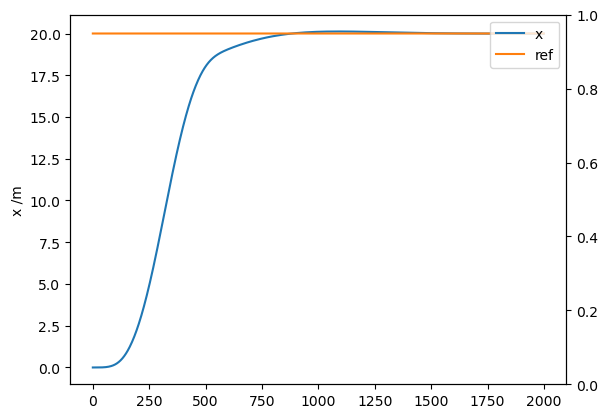

In [253]:
m = Multirotor(vp, sp)
pos = ctrl.ctrl_p
print(pos)
vel = ctrl.ctrl_v
print(vel)
rat = ctrl.ctrl_r
att = ctrl.ctrl_a
log = DataLog(vehicle=m, other_vars=('err', 'torques'))
for i in range(2000):
    ref = np.asarray([20.,0.])

    velocity = pos.step(ref, m.position[:2], dt=0.1)
    angles = vel.step(velocity, m.velocity[:2], dt=0.1)[::-1]
    rate = att.step(np.asarray([*angles, 0]), m.orientation, dt=0.01)
    action = rat.step(rate, m.euler_rate, dt=0.01)
    action = np.clip(action, a_min=-0.1, a_max=0.1)
    m.step_dynamics(np.asarray([0, 0, m.weight, *action]))
    log.log(err=pos.err[0], torques=action)
log.done_logging()

plt.plot(log.x, label='x')
plt.plot([ref[0]]*2000, label='ref')
plt.ylabel('x /m')
l = plt.gca().lines
plt.twinx()
plt.legend(handles=plt.gca().lines+l)
plt.show()

In [254]:
import pickle
with open('./params/manual_pid.pkl', 'wb') as file:
    pickle.dump(ctrl.get_params(), file)

## Defining Trajectories

## Test Experiment

In [265]:
best_agent = PIDAgent()
best_params = {'steps_u':1, 'scaling_factor':0, 'window_distance':1000}
env_selector = OctorotorEnvSelector()
square_wpts = np.array([[100,0,30], [100,100,30], [0,100,30], [0,0,30]])
references = []
errors = []
speeds = []

def run_trajectory(env_selector, wind_ranges: np.ndarray, agent, params):
    env = env_selector.get_env("sliding", params, wind_ranges, nasa_wp, start_alt=30, has_turbulence=False)
    params = env.base_env.ctrl.get_params()
    params['ctrl_p']['max_velocity'] = 15
    params['ctrl_v']['max_tilt'] = np.deg2rad(22.5)
    # params['ctrl_v']['k_i'] = params['ctrl_v']['k_i'] * 100# / 10
    
    env.base_env.ctrl.set_params(**params)
    done = False
    state = np.array(env.reset(), dtype=np.float32)
    log = DataLog(env.base_env.vehicle, env.base_env.ctrl,
                      other_vars=('reward',))
    while not done:
        action = agent.predict(state, deterministic=True)[0]
        state, reward, done, info = env.step(action)
        state = np.array(state, dtype=np.float32)
        log.log(reward=reward)
        errors.append([env.base_env.ctrl.ctrl_v.err_p, env.base_env.ctrl.ctrl_v.err_i])
        # speeds.append([log.vehicle.speeds])
        speeds.append([env.base_env.vehicle.speeds])

    log.done_logging()
    return log, info, np.array(errors), np.array(speeds)

log, info, errors, speeds = run_trajectory(env_selector, [(12,12), (0,0), (0,0)], best_agent, best_params)

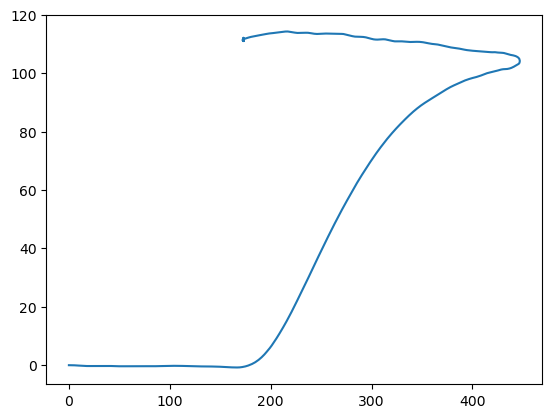

In [266]:
plt.plot(log.x, log.y)